In [1]:
import MeCab
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
m=MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/')  # NEologdへのパスを追加

text = "私は機械学習が好きです。"

text_segmented = m.parse(text)
print(text_segmented)

私	名詞,代名詞,一般,*,*,*,私,ワタシ,ワタシ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
機械学習	名詞,固有名詞,一般,*,*,*,機械学習,キカイガクシュウ,キカイガクシュー
が	助詞,格助詞,一般,*,*,*,が,ガ,ガ
好き	名詞,形容動詞語幹,*,*,*,*,好き,スキ,スキ
です	助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
。	記号,句点,*,*,*,*,。,。,。
EOS



# 日本語版BERTの学習済みモデルと形態素解析を用意

In [3]:
import torch
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer

In [4]:
#日本語用の分かち書きをするためのもの用意
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')

In [5]:
#日本語での学習済みモデルを用意 
model = BertModel.from_pretrained('bert-base-japanese-whole-word-masking')

# 東北大学が公開されているものを使用

In [6]:
from transformers import BertConfig

# 東北大学_日本語版の設定を確認
config_japanese = BertConfig.from_pretrained('bert-base-japanese-whole-word-masking')
print(config_japanese)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "tokenizer_class": "BertJapaneseTokenizer",
  "type_vocab_size": 2,
  "vocab_size": 32000
}



In [7]:
text1 = "会社をクビになった。"
text2 = "テレワークばかりでクビが痛い。"
text3 = "会社を解雇された。"

In [8]:
# 分かち書きをして、idに変換
input_ids1 = tokenizer.encode(text1, return_tensors='pt')  # ptはPyTorchの略
input_ids2 = tokenizer.encode(text2, return_tensors='pt') 
input_ids3 = tokenizer.encode(text3, return_tensors='pt') 
print(tokenizer.convert_ids_to_tokens(input_ids1[0].tolist()))  # 文章
print(input_ids1)  # id

['[CLS]', '会社', 'を', 'クビ', 'に', 'なっ', 'た', '。', '[SEP]']
tensor([[    2,   811,    11, 13700,     7,    58,    10,     8,     3]])


In [9]:
# 日本語BERTモデルに入力
result1 = model(input_ids1)
print(len(result1))
print(result1[0].shape)
print(result1[1].shape)

# reult は、sequence_output, pooled_output, (hidden_states), (attentions)です。
# ただし、hidden_statesとattentionsはoptionalであり、標準では出力されません。

2
torch.Size([1, 9, 768])
torch.Size([1, 768])


In [10]:
# 日本語BERTモデルに入力
result2 = model(input_ids2)
result3 = model(input_ids3)

word_vec1 = result1[0][0][3][:]  # 1つ目の文章の”クビ”（3番目）
word_vec2 = result2[0][0][5][:]  # 2つ目の文章の”クビ”（5番目）
word_vec3 = result3[0][0][3][:]  # 3つ目の文章の”解雇”（3番目）

In [11]:
cos = torch.nn.CosineSimilarity(dim=0)
cos_sim_12 = cos(word_vec1, word_vec2)
cos_sim_13 = cos(word_vec1, word_vec3)

print(cos_sim_12)
print(cos_sim_13)

tensor(0.6647, grad_fn=<DivBackward0>)
tensor(0.7841, grad_fn=<DivBackward0>)


In [12]:
len(result1[0][0][0])

768

In [13]:
len(result1[0][0][0])

768

In [14]:
import numpy as np
def get_vector_cls(text):
    input_ids = tokenizer.encode(text, return_tensors='pt') 
    result = model(input_ids)
    tensor_result = result[0][0][0]
    numpy_result = tensor_result.to('cpu').detach().numpy().copy()
    return numpy_result

#平均
def get_vector_mean(text):
    input_ids = tokenizer.encode(text, return_tensors='pt') 
    result = model(input_ids)
    vector = torch.zeros(len(result[0][0][0]))
    s =0
    for i in result[0][0]:
        vector += i
        s +=1
    tensor_result = vector/s
    numpy_result = tensor_result.to('cpu').detach().numpy().copy()
    return numpy_result

In [15]:
x = get_vector_cls("私は学生だ。")
x

array([ 1.35533974e-01,  2.93603867e-01, -2.71235228e-01, -2.58919209e-01,
       -5.01645088e-01,  5.31064987e-01,  1.03046633e-01, -2.86225170e-01,
        4.86509472e-01,  5.35140373e-02,  2.32363194e-01, -2.40713328e-01,
       -3.58814187e-02, -1.76531300e-02, -3.96478176e-02,  1.86456025e-01,
       -6.38352573e-01,  2.53652543e-01, -4.96920437e-01, -1.24119066e-01,
        6.62658334e-01, -4.51156527e-01, -2.22388864e-01,  5.25086597e-02,
        2.14874804e-01,  2.09335983e-02,  1.73652589e-01, -6.86154306e-01,
       -1.12390466e-01,  1.38899893e-01, -2.26559028e-01, -1.54478714e-01,
        2.46853769e-01, -6.36993170e-01, -7.23229796e-02, -5.77691138e-01,
       -4.11701724e-02, -5.67247808e-01,  4.07062292e-01, -1.19930041e+00,
        1.61955684e-01,  2.04550639e-01, -2.90022269e-02,  8.47229838e-01,
        4.61530507e-01, -3.83290738e-01,  3.10243905e-01,  3.12747329e-01,
        4.25210744e-01,  2.06110403e-01,  8.54631662e-01,  8.54570806e-01,
        6.85838938e-01, -

In [16]:
x = get_vector_mean("私は学生だ。")
x

array([ 5.28125688e-02,  1.96723372e-01,  1.94282442e-01, -1.08354248e-01,
       -5.55673957e-01,  1.18727922e-01,  9.01239440e-02,  1.95345073e-03,
        5.25353029e-02, -3.48018892e-02,  4.63512480e-01, -1.60717472e-01,
        5.21689132e-02, -7.34520331e-02,  1.49902478e-01, -9.86151844e-02,
       -2.77770936e-01,  1.56307101e-01, -3.51756573e-01, -3.85660559e-01,
        2.98571140e-01, -2.34431013e-01, -5.67057244e-02,  6.87958971e-02,
        1.41823560e-01,  3.63022506e-01,  5.46860695e-02, -4.03227717e-01,
       -3.00104525e-02,  1.13027386e-01, -3.99963230e-01,  1.13726541e-01,
       -1.95707587e-04, -1.69749901e-01, -3.29958707e-01, -3.94632131e-01,
       -6.36938140e-02, -2.58612216e-01,  6.64072394e-01, -6.73402727e-01,
        3.35252017e-01,  1.08793698e-01, -4.52205867e-01,  5.73052824e-01,
        2.35123947e-01,  1.54336289e-01, -2.78951317e-01,  3.30248415e-01,
        1.46991536e-01,  4.77549955e-02,  4.69200075e-01,  3.86505693e-01,
        4.82920647e-01, -

# 実験

In [17]:
import json

In [18]:
class Event:
    def __init__(self, id, type, score, desc, links):
        self.id = id
        self.type = type
        self.score = score
        self.desc = desc
        self.links = links

In [19]:
def load_events(jsonfile):
    with open(jsonfile) as f:
        df = json.load(f)
    events = {x['id']: Event(x['id'], x['type'], x['score'], x['desc'], x['links']) for x in df} #eventsにidをkeyとしそのオブジェクトをvalueとした辞書を生成
    for k,x in events.items():
        x.links = [events[e] for e in x.links] #Event.linkの中身をidの配列からEventの配列に変更
    return events

In [20]:
events = load_events('sesaku2.json')

In [21]:
import pandas as pd
data = []
labels = []
columns=[]
index=[]
for k1, v1 in events.items():
    if v1.type[-1]=='部品':
        index.append(v1.desc)
for k1, v1 in events.items():
    if v1.type[-1]=='対策':
        if not v1.desc in columns:
            columns.append(v1.desc)
df = pd.DataFrame(index=index, columns=columns)
for k1, v1 in events.items():
    if v1.type[-1]=='部品':
        for k2, v2 in events.items():
            if v2.type[-1] == '対策':
                    if v2 in v1.links:
                        df.at[v1.desc, v2.desc] = 1
                    else:
                        df.at[v1.desc, v2.desc] = 0
df

,前機種の振り返りを実施。目標に対する達成度、課題と次の一手を適用している,会社方針と中・長期計画を基に、商品企画と製品企画を経て、目標を設定している。,社会との調和、社会への貢献実現のビジョンがある,経営責任を明確化,的確な経営判断が９０％の迅速さで下されている,社長を補佐できるキーパーソンが各部門に存在,方針管理は部門別と機能別を組み合わせたマトリックスマネジメントで管理,日常管理が各機能ごとに項目と目標が明確で、管理責任者も設定,管理目標から外れた場合のアクションが取られている,QCDの視点で、目標を設定。関連部品にも目標展開、仕様を決めた後、全体目標をアラインしている。,...,異常有無を全数検査している（外観・異音・振動等）,プランジャ当たり面の検査は、定量化・仕組み化・標準化しているか,インジェクターの色識別（品番との合致）,噴射レベルの抜き取り検査,エンジン性能の検査（トヨタ）,"機能テストは、設計指示の環境条件を満足しているか (燃料,温度,気圧 等)",インジェクターをエンジンに挿入する時の抵抗測定をする,バリ、異物有無を検査している（画像検査等）,機能検査を実施している（電流ｘ噴射量）,リーク検査を実施しているる
エンジン搭載 吸気レゾネーター,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ポンプ 抵抗器アセンブリ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ポンプ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 ゴム クッション,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料圧力ダンパー,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ポンプ 抵抗カバー,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料フィルター,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料パイプ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料蒸気供給ホース,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ホース クランプ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [22]:
df.shape

(173, 319)

In [23]:
taisaku_vec_cls = {}
for i in df:
    taisaku_vec_cls[i]=get_vector_cls(i)

In [24]:
taisaku_vec_mean = {}
for i in df:
    taisaku_vec_mean[i]=get_vector_mean(i)

In [25]:
class Label:
    TAISAKU = 1
    NASI = 0

data_BERT_cls = []
labels_BERT_cls = []
# data 
for index, row in df.iterrows():#部品
    x1 = get_vector_cls(index) #部品
    for i in df:#対策
        x2=taisaku_vec_cls[i]
        data_BERT_cls.extend([np.append(x1, x2)])
        if row[i] ==1:
            labels_BERT_cls.append(Label.TAISAKU)
        else:
            labels_BERT_cls.append(Label.NASI)

In [26]:
data_BERT_mean= []
labels_BERT_mean = []
# data 
for index, row in df.iterrows():#部品
    x1 = get_vector_mean(index) #部品
    for i in df:#対策
        x2=taisaku_vec_mean[i]
        data_BERT_mean.extend([np.append(x1, x2)])
        if row[i] ==1:
            labels_BERT_mean.append(Label.TAISAKU)
        else:
            labels_BERT_mean.append(Label.NASI)

In [27]:
def train_data(data,labels):
    index_1 = [i for i, x in enumerate(labels) if x == 1]
    index_0 = [i for i, x in enumerate(labels) if x == 0]
    index_0 = random.sample(index_0, len(index_1))
    data_1 = [data[i] for i in index_1]
    data_0 = [data[i] for i in index_0]
    labels = [Label.TAISAKU]*len(data_1) + [Label.NASI]*len(data_0) 
    data = data_1 + data_0
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [29]:
data_BERT_cls2,labels_BERT_cls2 = train_data(data_BERT_cls,labels_BERT_cls)
print(data_BERT_cls2.shape,labels_BERT_cls2.shape)

(14606, 1536) (14606,)


In [30]:
def gakusyu(data,labels):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    print('トレーニングデータの1の数    :',y_train.sum())
    print('トレーニングデータ1の割合    :',round(y_train.sum()/x_train.shape[0]*100,1),'%')
    print('テストデータの１の数            :',y_test.sum())
    print('テストデータの1の割合          :',round(y_test.sum()/x_test.shape[0]*100,1),'%')
    # y_train を one-hot 表現にする。
    y_train_one_hot = np_utils.to_categorical(y_train)
    y_test_one_hot = np_utils.to_categorical(y_test)
    # モデルを作成する。
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=x_train.shape[1:])) #activation
    #model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.compile(
        optimizer=Adam(lr=0.001), #最適化アルゴリズムの種類.sgd,rmsprop,adam,adagrad,nadam,adadeltaなどある。
        loss='categorical_crossentropy', #損失関数名
        metrics=['accuracy']) #訓練やテストの際にモデルを評価するための評価関数のリスト． 典型的には metrics=['accuracy']を使用する.

    # 学習を実行する。
    result = model.fit(x_train, y_train_one_hot , batch_size=16, epochs=30,validation_data=(x_test, y_test_one_hot )) #epochs 学習回数,batch_size 重みを調整の際に行う平均化のときに使うデータの数（dataの数/batch_size回）×epochs

    # 推論する。
    prob = model.predict(x_test, batch_size=len(x_test))

    # 最も確率が高いのを推定クラスとする。
    y_pred = np.argmax(prob, axis=1)

    # 精度を検証する。
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy: {:.2%}'.format(accuracy))
    return result, accuracy, model, x_test, y_test_one_hot

In [31]:
history = {'BERT_cls':0,'BERT_cls_count':0,'BERT_mean':0,'BERT_mean_count':0}
BERT_cls_result = []
BERT_mean_result = []

In [32]:
for i in range(10):
    data_BERT_cls2, labels_BERT_cls2= train_data(data_BERT_cls,labels_BERT_cls)
    result, accuracy, model, x_test, y_test = gakusyu(data_BERT_cls2, labels_BERT_cls2)
    history['BERT_cls'] = history['BERT_cls'] + accuracy
    history['BERT_cls_count'] += 1
    BERT_cls_result.append(result)

トレーニングデータの1の数    : 5882
トレーニングデータ1の割合    : 50.3 %
テストデータの１の数            : 1421
テストデータの1の割合          : 48.6 %
Epoch 1/30
731/731 [==============================] - 1s 1ms/step - loss: 0.2612 - accuracy: 0.8946 - val_loss: 0.1791 - val_accuracy: 0.9220
Epoch 2/30
731/731 [==============================] - 1s 864us/step - loss: 0.1055 - accuracy: 0.9641 - val_loss: 0.0929 - val_accuracy: 0.9617
Epoch 3/30
731/731 [==============================] - 1s 854us/step - loss: 0.0835 - accuracy: 0.9692 - val_loss: 0.0684 - val_accuracy: 0.9781
Epoch 4/30
731/731 [==============================] - 1s 968us/step - loss: 0.0477 - accuracy: 0.9831 - val_loss: 0.0573 - val_accuracy: 0.9791
Epoch 5/30
731/731 [==============================] - 1s 948us/step - loss: 0.0417 - accuracy: 0.9850 - val_loss: 0.0220 - val_accuracy: 0.9925
Epoch 6/30
731/731 [==============================] - 1s 889us/step - loss: 0.0282 - accuracy: 0.9895 - val_loss: 0.0433 - val_accuracy: 0.9812
Epoch 7/30
731/731 [=========

731/731 [==============================] - 1s 880us/step - loss: 0.0043 - accuracy: 0.9983 - val_loss: 0.0046 - val_accuracy: 0.9973
Epoch 21/30
731/731 [==============================] - 1s 920us/step - loss: 0.0140 - accuracy: 0.9954 - val_loss: 0.0152 - val_accuracy: 0.9932
Epoch 22/30
731/731 [==============================] - 1s 1ms/step - loss: 0.0126 - accuracy: 0.9968 - val_loss: 0.0070 - val_accuracy: 0.9973
Epoch 23/30
731/731 [==============================] - 1s 992us/step - loss: 7.4747e-04 - accuracy: 0.9998 - val_loss: 0.0060 - val_accuracy: 0.9979
Epoch 24/30
731/731 [==============================] - 1s 1ms/step - loss: 2.1657e-04 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9979
Epoch 25/30
731/731 [==============================] - 1s 950us/step - loss: 1.1572e-04 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9983
Epoch 26/30
731/731 [==============================] - 1s 916us/step - loss: 4.7825e-05 - accuracy: 1.0000 - val_loss: 0.0030 - val_ac

731/731 [==============================] - 1s 917us/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0040 - val_accuracy: 0.9986
Epoch 30/30
731/731 [==============================] - 1s 946us/step - loss: 1.2167e-04 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9979
accuracy: 99.79%
トレーニングデータの1の数    : 5868
トレーニングデータ1の割合    : 50.2 %
テストデータの１の数            : 1435
テストデータの1の割合          : 49.1 %
Epoch 1/30
731/731 [==============================] - 1s 1ms/step - loss: 0.2561 - accuracy: 0.8966 - val_loss: 0.1515 - val_accuracy: 0.9565
Epoch 2/30
731/731 [==============================] - 1s 893us/step - loss: 0.1087 - accuracy: 0.9620 - val_loss: 0.0977 - val_accuracy: 0.9733
Epoch 3/30
731/731 [==============================] - 1s 884us/step - loss: 0.0628 - accuracy: 0.9767 - val_loss: 0.0630 - val_accuracy: 0.9760
Epoch 4/30
731/731 [==============================] - 1s 872us/step - loss: 0.0403 - accuracy: 0.9854 - val_loss: 0.0385 - val_accuracy: 0.9884
Epoch 5/30
731/731

accuracy: 99.59%


In [33]:
for i in range(10):
    data_BERT_mean2, labels_BERT_mean2= train_data(data_BERT_mean,labels_BERT_mean)
    result, accuracy, model, x_test, y_test = gakusyu(data_BERT_mean2, labels_BERT_mean2)
    history['BERT_mean'] = history['BERT_mean'] + accuracy
    history['BERT_mean_count'] += 1
    BERT_mean_result.append(result)

トレーニングデータの1の数    : 5843
トレーニングデータ1の割合    : 50.0 %
テストデータの１の数            : 1460
テストデータの1の割合          : 50.0 %
Epoch 1/30
731/731 [==============================] - 1s 987us/step - loss: 0.2819 - accuracy: 0.8800 - val_loss: 0.1351 - val_accuracy: 0.9582
Epoch 2/30
731/731 [==============================] - 1s 869us/step - loss: 0.1057 - accuracy: 0.9644 - val_loss: 0.0951 - val_accuracy: 0.9747
Epoch 3/30
731/731 [==============================] - 1s 869us/step - loss: 0.0635 - accuracy: 0.9760 - val_loss: 0.0676 - val_accuracy: 0.9740
Epoch 4/30
731/731 [==============================] - 1s 896us/step - loss: 0.0426 - accuracy: 0.9843 - val_loss: 0.0468 - val_accuracy: 0.9825
Epoch 5/30
731/731 [==============================] - 1s 905us/step - loss: 0.0315 - accuracy: 0.9894 - val_loss: 0.0323 - val_accuracy: 0.9890
Epoch 6/30
731/731 [==============================] - 1s 938us/step - loss: 0.0161 - accuracy: 0.9947 - val_loss: 0.0194 - val_accuracy: 0.9952
Epoch 7/30
731/731 [=======

Epoch 4/30
731/731 [==============================] - 1s 847us/step - loss: 0.0480 - accuracy: 0.9836 - val_loss: 0.0372 - val_accuracy: 0.9887
Epoch 5/30
731/731 [==============================] - 1s 861us/step - loss: 0.0366 - accuracy: 0.9868 - val_loss: 0.0356 - val_accuracy: 0.9901
Epoch 6/30
731/731 [==============================] - 1s 913us/step - loss: 0.0210 - accuracy: 0.9914 - val_loss: 0.0550 - val_accuracy: 0.9839
Epoch 7/30
731/731 [==============================] - 1s 911us/step - loss: 0.0133 - accuracy: 0.9950 - val_loss: 0.0200 - val_accuracy: 0.9935
Epoch 8/30
731/731 [==============================] - 1s 902us/step - loss: 0.0251 - accuracy: 0.9909 - val_loss: 0.0169 - val_accuracy: 0.9935
Epoch 9/30
731/731 [==============================] - 1s 915us/step - loss: 0.0049 - accuracy: 0.9984 - val_loss: 0.0123 - val_accuracy: 0.9976
Epoch 10/30
731/731 [==============================] - 1s 915us/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.0265 - val_accuracy

731/731 [==============================] - 1s 929us/step - loss: 0.0089 - accuracy: 0.9967 - val_loss: 0.0174 - val_accuracy: 0.9945
Epoch 9/30
731/731 [==============================] - 1s 952us/step - loss: 0.0195 - accuracy: 0.9932 - val_loss: 0.0074 - val_accuracy: 0.9973
Epoch 10/30
731/731 [==============================] - 1s 954us/step - loss: 0.0107 - accuracy: 0.9966 - val_loss: 0.0134 - val_accuracy: 0.9976
Epoch 11/30
731/731 [==============================] - 1s 1ms/step - loss: 0.0173 - accuracy: 0.9951 - val_loss: 0.0323 - val_accuracy: 0.9897
Epoch 12/30
731/731 [==============================] - 1s 1ms/step - loss: 0.0061 - accuracy: 0.9981 - val_loss: 0.0042 - val_accuracy: 0.9986
Epoch 13/30
731/731 [==============================] - 1s 969us/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0380 - val_accuracy: 0.9870
Epoch 14/30
731/731 [==============================] - 1s 987us/step - loss: 0.0137 - accuracy: 0.9948 - val_loss: 0.0082 - val_accuracy: 0.9976
Ep

731/731 [==============================] - 1s 960us/step - loss: 0.0057 - accuracy: 0.9975 - val_loss: 0.0089 - val_accuracy: 0.9976
Epoch 13/30
731/731 [==============================] - 1s 958us/step - loss: 0.0234 - accuracy: 0.9929 - val_loss: 0.0117 - val_accuracy: 0.9959
Epoch 14/30
731/731 [==============================] - 1s 922us/step - loss: 0.0062 - accuracy: 0.9979 - val_loss: 0.0098 - val_accuracy: 0.9983
Epoch 15/30
731/731 [==============================] - 1s 911us/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0080 - val_accuracy: 0.9969
Epoch 16/30
731/731 [==============================] - 1s 906us/step - loss: 0.0190 - accuracy: 0.9931 - val_loss: 0.0096 - val_accuracy: 0.9983
Epoch 17/30
731/731 [==============================] - 1s 909us/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0082 - val_accuracy: 0.9986
Epoch 18/30
731/731 [==============================] - 1s 894us/step - loss: 0.0138 - accuracy: 0.9951 - val_loss: 0.0142 - val_accuracy: 0.99

In [34]:
BERT_cls_result_all = {'accuracy':[0]*30,'val_accuracy':[0]*30}
for k,v in BERT_cls_result_all.items():
    for i in range(30):
        for j in BERT_cls_result:
            v[i] += j.history[k][i]
        v[i] /= 10
BERT_mean_result_all = {'accuracy':[0]*30,'val_accuracy':[0]*30}
for k,v in BERT_mean_result_all.items():
    for i in range(30):
        for j in BERT_mean_result:
            v[i] += j.history[k][i]
        v[i] /= 10

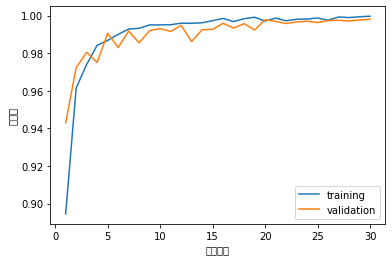

In [37]:
plt.plot(range(1, 30+1),BERT_cls_result_all['accuracy'] , label="training")
plt.plot(range(1, 30+1), BERT_cls_result_all['val_accuracy'], label="validation")
plt.xlabel('学習回数')
plt.ylabel('正解率')
plt.legend()
plt.show()

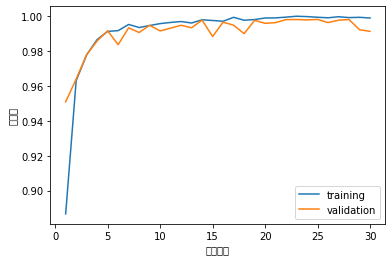

In [38]:
plt.plot(range(1, 30+1),BERT_mean_result_all['accuracy'] , label="training")
plt.plot(range(1, 30+1), BERT_mean_result_all['val_accuracy'], label="validation")
plt.xlabel('学習回数')
plt.ylabel('正解率')
plt.legend()
plt.show()

In [42]:
max(BERT_cls_result_all['val_accuracy'])

0.9980835080146789

In [43]:
max(BERT_mean_result_all['val_accuracy'])

0.99808349609375